# Data Preprocessing 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)


def load_and_preprocess_data(filepath, sample_frac=0.5):
    """Load data and preprocess with memory efficiency"""
    # Read data in chunks
    chunks = pd.read_csv(filepath, chunksize=10000)
    df = pd.concat(chunks)
    
    # Sample data if too large
    if len(df) > 100000:
        df = df.sample(frac=sample_frac, random_state=42)
    
    # Convert Order Date to datetime and extract features
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['DayOfWeek'] = df['Order Date'].dt.dayofweek
    df['Hour'] = df['Order Date'].dt.hour
    df['is_weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create price category feature (more memory efficient than one-hot)
    df['price_category'] = pd.cut(df['Price Each'], 
                                 bins=[0, 50, 200, 500, 2000], 
                                 labels=[0, 1, 2, 3])
    
    # Clean city names and label encode
    df['City'] = df['City'].str.strip()
    le = LabelEncoder()
    df['City_encoded'] = le.fit_transform(df['City'])

    
    return df
    
len(df)

55785

# Feature Engineering

In [ ]:
def prepare_features(df):
    """Prepare features with minimal memory usage"""
    # Select only the columns we need
    features = df[['DayOfWeek', 'Hour', 'is_weekend', 'Quantity Ordered', 
                  'price_category', 'City_encoded']].copy()
    
    # Target variable
    target = df['Sales'].values
    
    return features, target


# Model Building

In [ ]:
def train_model(X, y):
    """Train memory-efficient model"""p
    # HistGradientBoosting is more memory efficient than RandomForest
    model = HistGradientBoostingRegressor(
        max_iter=100,
        random_state=42,
        max_depth=6,
        min_samples_leaf=20
    )
    
    model.fit(X, y)
    return model

# Prediction Function

In [ ]:
def predict_sales(model, product_data, city_encoder, city_list):
    """Make predictions with the trained model"""

    # Check for unknown city
    if product_data['city'] not in city_encoder.classes_:
        raise ValueError(f"City '{product_data['city']}' not in training data. Available cities: {city_list}")

    # Prepare input features
    input_features = pd.DataFrame({
        'DayOfWeek': [product_data['day_of_week']],
        'Hour': [product_data['hour']],
        'is_weekend': [1 if product_data['day_of_week'] >= 5 else 0],
        'Quantity Ordered': [product_data['quantity']],
        'price_category': [product_data['price_category']],
        'City_encoded': [city_encoder.transform([product_data['city']])[0]]
    })

    return model.predict(input_features)[0]



# Example

In [ ]:
if __name__ == "__main__":
    # Load and preprocess data
    df = load_and_preprocess_data('Sales Data.csv', sample_frac=0.3)
    
    # Prepare features
    X, y = prepare_features(df)
    
    # Get city encoder for later use
    le = LabelEncoder()
    le.fit(df['City'])
    city_list = list(le.classes_)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train model
    model = train_model(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Model RMSE: {rmse:.2f}")
    
    # Example prediction
    example_data = {
        'day_of_week': 2,  # Wednesday
        'hour': 14,        # 2PM
        'quantity': 2,
        'price_category': 3,  # premium
        'city': 'New York City'
    }
    
    predicted_sales = predict_sales(model, example_data, le, city_list)
    print(f"Predicted sales: ${predicted_sales:.2f}")

Model RMSE: 147.24
Predicted sales: $925.92


Model RMSE: 147.24
Predicted sales: $925.92


# Feature Importance Plot

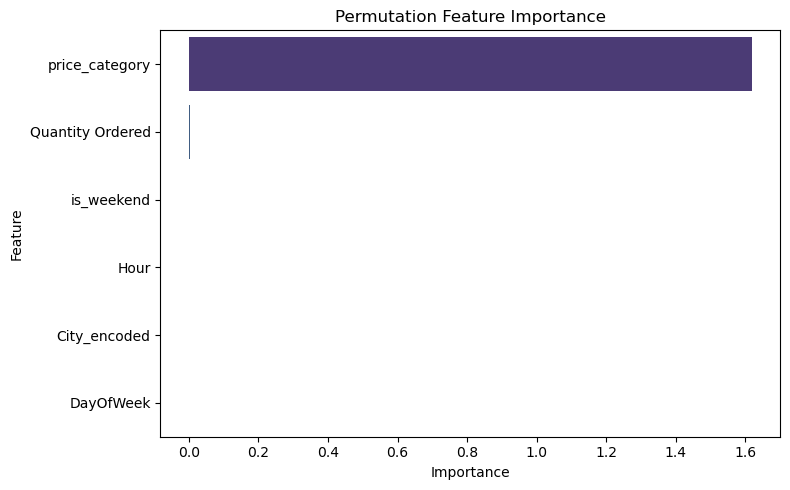

In [ ]:
from sklearn.inspection import permutation_importance

def plot_feature_importance(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title("Permutation Feature Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, X_test, y_test)

# Predicated vs Actual Sales Plot

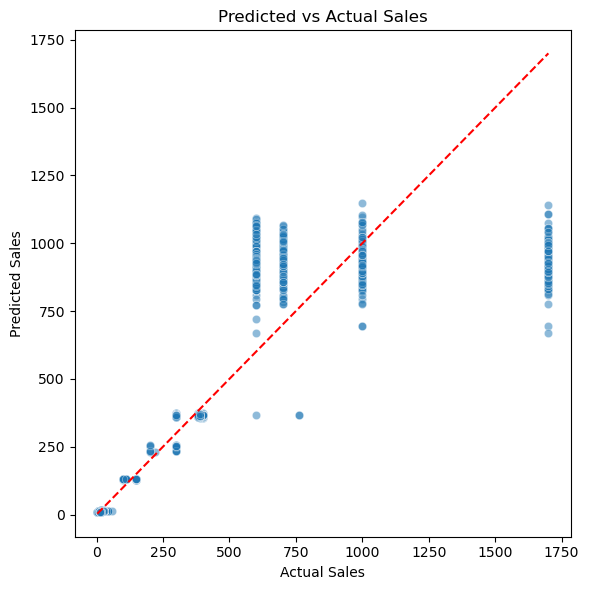

In [ ]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel("Actual Sales")
    plt.ylabel("Predicted Sales")
    plt.title("Predicted vs Actual Sales")
    plt.tight_layout()
    plt.show()
plot_predictions(y_test, y_pred)

# Sales by Day of Week or Hour

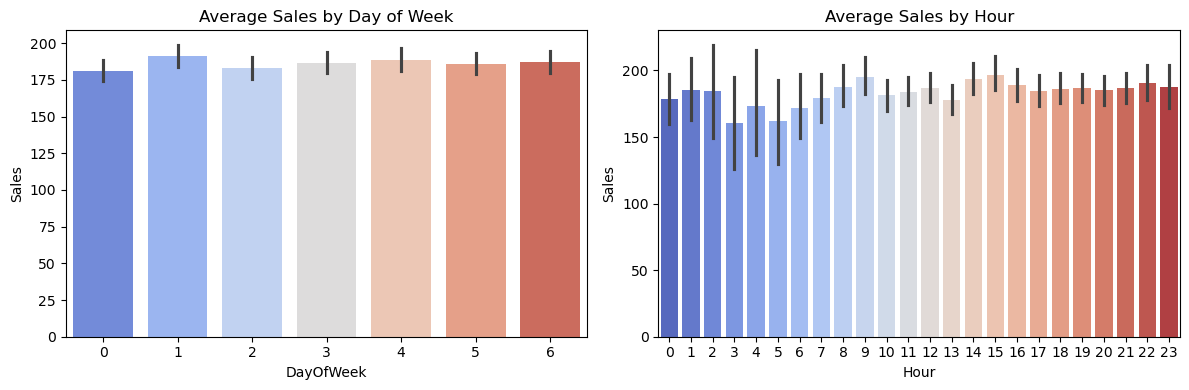

In [ ]:
def plot_sales_by_time(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.barplot(x='DayOfWeek', y='Sales', data=df, ax=axes[0], palette='coolwarm')
    axes[0].set_title("Average Sales by Day of Week")

    sns.barplot(x='Hour', y='Sales', data=df, ax=axes[1], palette='coolwarm')
    axes[1].set_title("Average Sales by Hour")

    plt.tight_layout()
    plt.show()

plot_sales_by_time(df)


In [ ]:
# plt.savefig("plot_sales_by_time.png", dpi=300)

<Figure size 640x480 with 0 Axes>

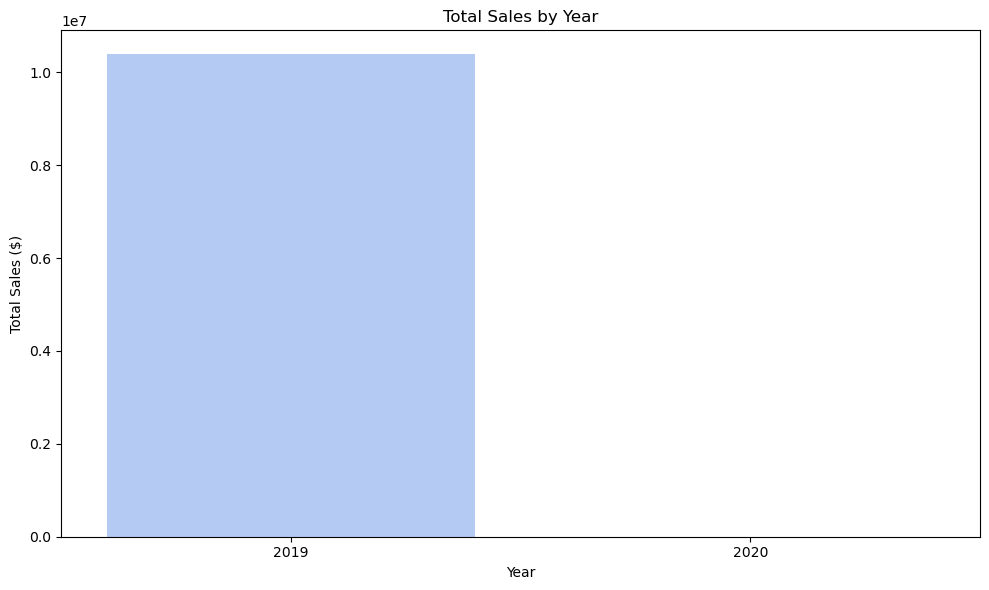

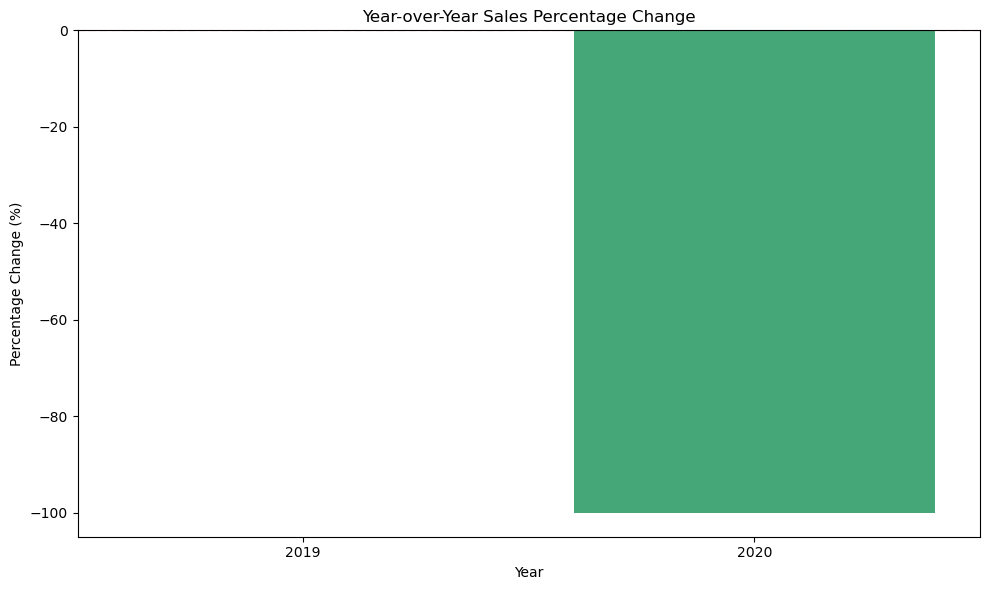


⚠️ Sales decreased from 2019 to 2020 by 99.99%.
Possible reasons:
- Customers bought more products on average (+0.38 items).
- Average product price decreased by $27.17.
- Shift in top-selling city from San Francisco to Boston.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_yearly_sales(df):
    """Analyze and visualize sales growth or decline between years."""
    # Extract year from Order Date
    df['Year'] = df['Order Date'].dt.year
    
    # Aggregate total sales per year
    sales_by_year = df.groupby('Year')['Sales'].sum().reset_index()
    
    # Calculate year-over-year percentage change
    sales_by_year['Pct_Change'] = sales_by_year['Sales'].pct_change() * 100
    
    # Plot sales over years
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Year', y='Sales', data=sales_by_year, palette='coolwarm')
    plt.title("Total Sales by Year")
    plt.ylabel("Total Sales ($)")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()
    
    # Plot percentage change
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Year', y='Pct_Change', data=sales_by_year, palette='viridis')
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Year-over-Year Sales Percentage Change")
    plt.ylabel("Percentage Change (%)")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()

    # Reasoning Analysis
    for i in range(1, len(sales_by_year)):
        year1 = sales_by_year.loc[i-1, 'Year']
        year2 = sales_by_year.loc[i, 'Year']
        change = sales_by_year.loc[i, 'Pct_Change']
        if change > 0:
            print(f"\n✅ Sales increased from {year1} to {year2} by {change:.2f}%.")
            print("Possible reasons:")
        else:
            print(f"\n⚠️ Sales decreased from {year1} to {year2} by {abs(change):.2f}%.")
            print("Possible reasons:")
        # Investigate: average quantity ordered and average price
        avg_quantity_change = (df[df['Year'] == year2]['Quantity Ordered'].mean() - 
                               df[df['Year'] == year1]['Quantity Ordered'].mean())
        avg_price_change = (df[df['Year'] == year2]['Price Each'].mean() - 
                            df[df['Year'] == year1]['Price Each'].mean())
        
        if avg_quantity_change > 0:
            print(f"- Customers bought more products on average (+{avg_quantity_change:.2f} items).")
        else:
            print(f"- Customers bought fewer products on average ({avg_quantity_change:.2f} items).")
        
        if avg_price_change > 0:
            print(f"- Average product price increased by ${avg_price_change:.2f}.")
        else:
            print(f"- Average product price decreased by ${abs(avg_price_change):.2f}.")
        
        # Check if a specific city contributed
        top_city_year1 = df[df['Year'] == year1].groupby('City')['Sales'].sum().idxmax()
        top_city_year2 = df[df['Year'] == year2].groupby('City')['Sales'].sum().idxmax()
        if top_city_year1 != top_city_year2:
            print(f"- Shift in top-selling city from {top_city_year1} to {top_city_year2}.")

analyze_yearly_sales(df)

# 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings


warnings.filterwarnings("ignore", category=FutureWarning)


def load_and_preprocess_data(filepath, sample_frac=0.5):
    """Load data and preprocess with memory efficiency"""
    # Read data in chunks
    chunks = pd.read_csv(filepath, chunksize=10000)
    df = pd.concat(chunks)
    
    # Sample data if too large
    if len(df) > 100000:
        df = df.sample(frac=sample_frac, random_state=42)
    
    # Convert Order Date to datetime and extract features
    df['Order Date'] = pd.to_datetime(df['Order Date'])
    df['DayOfWeek'] = df['Order Date'].dt.dayofweek
    df['Hour'] = df['Order Date'].dt.hour
    df['is_weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create price category feature (more memory efficient than one-hot)
    df['price_category'] = pd.cut(df['Price Each'], 
                                 bins=[0, 50, 200, 500, 2000], 
                                 labels=[0, 1, 2, 3])
    # Add this line before encoding cities
    df['City'] = df['City'].str.strip()

# Clean city names and label encode
    df['City'] = df['City'].str.strip()
    le = LabelEncoder()
    df['City_encoded'] = le.fit_transform(df['City'])

    
    return df

def prepare_features(df):
    """Prepare features with minimal memory usage"""
    # Select only the columns we need
    features = df[['DayOfWeek', 'Hour', 'is_weekend', 'Quantity Ordered', 
                  'price_category', 'City_encoded']].copy()
    
    # Target variable
    target = df['Sales'].values
    
    return features, target

def train_model(X, y):
    """Train memory-efficient model"""
    # HistGradientBoosting is more memory efficient than RandomForest
    model = HistGradientBoostingRegressor(
        max_iter=100,
        random_state=42,
        max_depth=6,
        min_samples_leaf=20
    )
    
    model.fit(X, y)
    return model

def predict_sales(model, product_data, city_encoder, city_list):
    """Make predictions with the trained model"""

    # Check for unknown city
    if product_data['city'] not in city_encoder.classes_:
        raise ValueError(f"City '{product_data['city']}' not in training data. Available cities: {city_list}")

    # Prepare input features
    input_features = pd.DataFrame({
        'DayOfWeek': [product_data['day_of_week']],
        'Hour': [product_data['hour']],
        'is_weekend': [1 if product_data['day_of_week'] >= 5 else 0],
        'Quantity Ordered': [product_data['quantity']],
        'price_category': [product_data['price_category']],
        'City_encoded': [city_encoder.transform([product_data['city']])[0]]
    })

    return model.predict(input_features)[0]


# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    df = load_and_preprocess_data('Sales Data.csv', sample_frac=0.3)
    
    # Prepare features
    X, y = prepare_features(df)
    
    # Get city encoder for later use
    le = LabelEncoder()
    le.fit(df['City'])
    city_list = list(le.classes_)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train model
    model = train_model(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Model RMSE: {rmse:.2f}")
    
    # Example prediction
    example_data = {
        'day_of_week': 2,  # Wednesday
        'hour': 14,        # 2PM
        'quantity': 2,
        'price_category': 3,  # premium
        'city': 'New York City'
    }
    
    predicted_sales = predict_sales(model, example_data, le, city_list)
    print(f"Predicted sales: ${predicted_sales:.2f}")

Model RMSE: 147.24
Predicted sales: $925.92
